<a href="https://colab.research.google.com/github/quangviet/python4engineer/blob/main/Problem_2/problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thông tin học viên

Học viên: Phạm Quang Việt

Mã học viên: 22MSE23069

Email: viet22mse23069@fsb.edu.vn

Bài 2 - Lập trình vẽ biểu đồ

# **Prepare data set and preprocess data format**

In [1]:
%env KAGGLE_USERNAME=quangviet
%env KAGGLE_KEY=e78ec69319c278806b1208176ad50255
!kaggle competitions download -c m5-forecasting-accuracy
!unzip -o /content/m5-forecasting-accuracy.zip -d ./input

env: KAGGLE_USERNAME=quangviet
env: KAGGLE_KEY=e78ec69319c278806b1208176ad50255
m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/m5-forecasting-accuracy.zip
  inflating: ./input/calendar.csv    
  inflating: ./input/sales_train_evaluation.csv  
  inflating: ./input/sales_train_validation.csv  
  inflating: ./input/sample_submission.csv  
  inflating: ./input/sell_prices.csv  


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sale_df = pd.read_csv('./input/sales_train_validation.csv')
cal_df = pd.read_csv('./input/calendar.csv')
price_df = pd.read_csv("./input/sell_prices.csv")        


# Convert date format d_day to actual date
import datetime

x = datetime.date(2011,1,29)
for c in ((sale_df.columns)[6:]):
    sale_df.rename(columns = {c:x}, inplace = True)
    x = x + datetime.timedelta(days = 1)

./input/sample_submission.csv
./input/calendar.csv
./input/sales_train_evaluation.csv
./input/sales_train_validation.csv
./input/sell_prices.csv


In [3]:
# Import visualize library
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

# **Sales of first 3 items as time series**

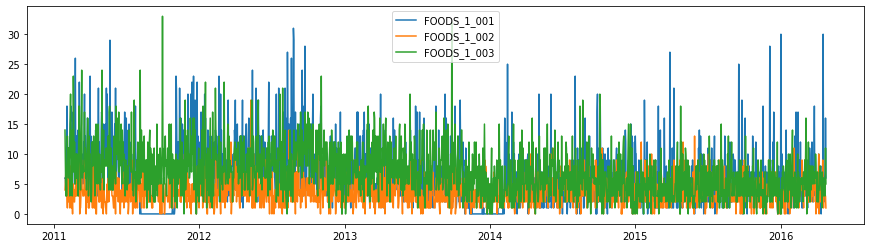

In [4]:
X = sale_df.groupby('item_id')[(sale_df.columns)[6:]].sum()

plt.figure(figsize = (15,4))
for i in range(3):
    plt.plot(X.iloc[i,:],label=X.index[i])
    plt.legend()

# **Total sales as time series**

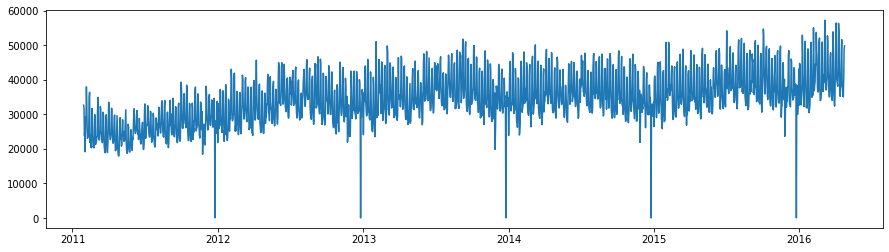

In [5]:
plt.figure(figsize = (15,4))
X.sum().plot()

# **Monthly sales in different cities**

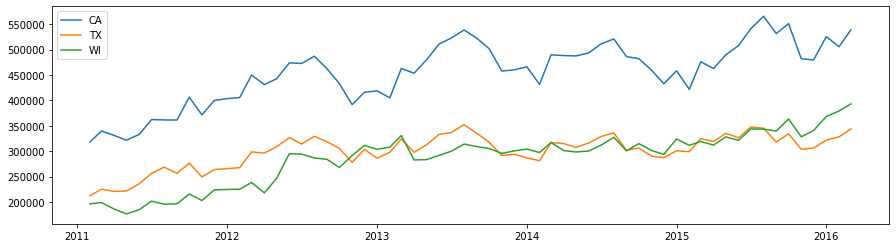

In [6]:
sale_by_date = sale_df.groupby(sale_df.columns.map(lambda x : x if type(x) == str else x.strftime('%Y-%m')), axis = 1).sum()
for c in ((sale_by_date.columns)[:-6]):
    x = datetime.datetime.strptime(c, '%Y-%m').date()
    sale_by_date.rename(columns = {c:x}, inplace = True)

sale_by_state = sale_by_date.groupby(['state_id'])[(sale_by_date.columns)[:-6]].sum()
plt.figure(figsize = (15,4))
for i in range(3):
    plt.plot(sale_by_state.iloc[i,1:-1],label = sale_by_state.index[i])
    plt.legend()

# **Monthly sales of different categories**

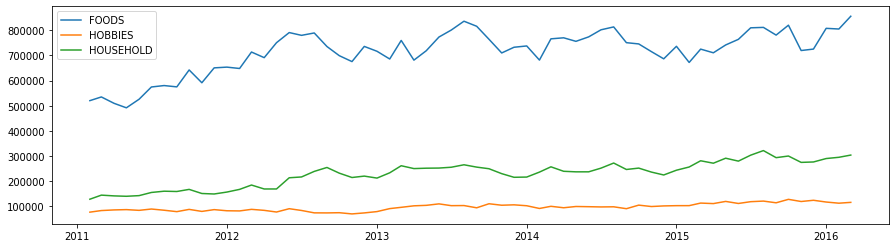

In [7]:
sale_by_cat = sale_by_date.groupby(['cat_id'])[(sale_by_date.columns)[:-6]].sum()
plt.figure(figsize = (15,4))
for i in range(3):
    plt.plot(sale_by_cat.iloc[i,1:-1],label = sale_by_cat.index[i])
    plt.legend()

# **Total Sales per category**

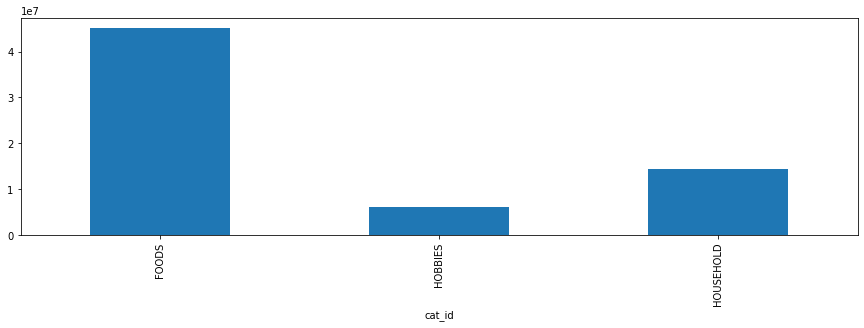

In [8]:
plt.figure(figsize = (15,4))
sale_by_cat.sum(axis=1).plot.bar()

# **Monthly sales in different stores**

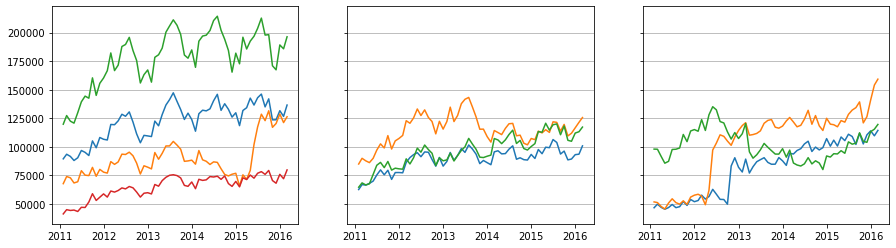

In [9]:
sale_by_store = sale_by_date.groupby(['store_id'])[(sale_by_date.columns)[:-6]].sum()
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (15,4))
for i in range(10):
    n = lambda x : 0 if x == 'C' else (1 if x == 'T' else 2)
    n = n(sale_by_store.index[i][0])
    ax[n].plot(sale_by_store.iloc[i,1:-1], label = sale_by_store.index[i])
    ax[n].grid(b = True, axis = 'y')

# **Monthly Sales in Different Departments of three States**

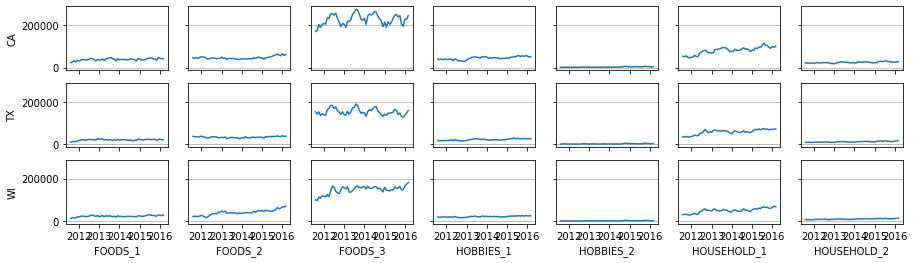

In [10]:
F = sale_by_date.groupby(['state_id','dept_id'])[(sale_by_date.columns)[6:]].sum()
fig, ax = plt.subplots(3, 7, sharey = True, sharex = True,figsize = (15,4))
for i in range(3):
    for j in range(7):
        k = (7*i)+(j)
        ax[i,j].plot(F.iloc[k,1:-1])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = F.index[k][1], ylabel = F.index[k][0])
for a in ax.flat:
    a.label_outer()

# **Total Sales with Smoothing fit**

In [11]:
F = sale_df.drop(labels=[datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)],axis=1)

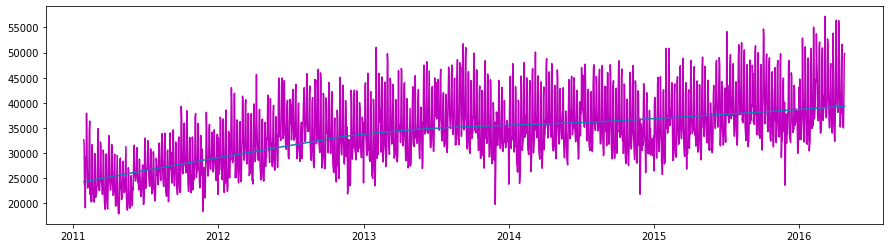

In [12]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
S = F.iloc[:,6:].sum()
z = lowess(S.values, range(S.shape[0]))
plt.figure(figsize = (15,4))
plt.plot(S,color='m')
plt.plot(pd.Series(z[:,1],S.index))

# **Seasonality in Residuals**


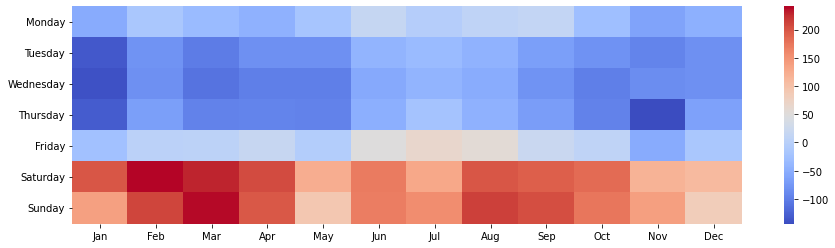

In [13]:
M = F.iloc[:,6:].sum()
z = lowess(M, range(M.shape[0]))
Z = M.values - z[:,1]
A = (pd.DataFrame(data=Z,index=M.index)).T
A = A.groupby(A.columns.map(lambda x : str(x.weekday())+'-'+str(x.month)),axis=1).sum()
H = np.zeros((7,12))
for i in range(7):
    for j in range(12):
        H[i,j] = A[str(i)+'-'+str(j+1)]//1000
        
plt.figure(figsize = (15,4))
ax = sns.heatmap(H,cmap='coolwarm',xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday' ])


# **Sales per state with seasonalities**

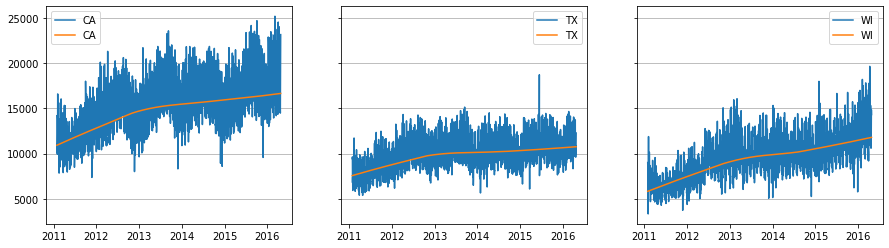

In [14]:
M = F.groupby(['state_id'])[(F.columns)[6:]].sum()
fig, ax = plt.subplots(1, 3, sharey=True, figsize = (15,4))

for i in range(3):
    ax[i].plot(M.iloc[i,:],label=M.index[i])
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    ax[i].plot(pd.Series(z[:,1],M.columns),label = M.index[i])
    ax[i].grid(b=True,axis='y')
    ax[i].legend()

# **Weekly Seasonality**

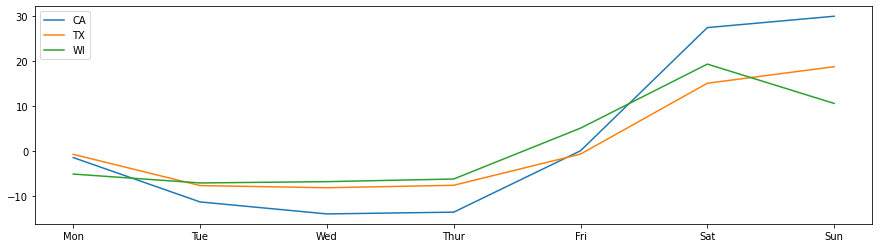

In [15]:
mean_sales = F.iloc[:,6:].sum().mean()

A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
f = A.groupby(A.columns.map(lambda x : str(x.weekday())),axis=1).sum()
plt.figure(figsize = (15,4))
for i in range(3):
    plt.plot(f.iloc[i,:],label=f.index[i])
    plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
    plt.legend()

# **Monthly Seasonality**

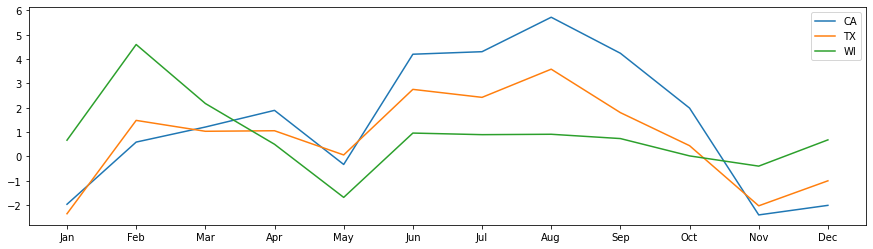

In [16]:
f = A.groupby(A.columns.map(lambda x : (x.month)),axis=1).sum()
plt.figure(figsize = (15,4))
for i in range(3):
    plt.plot(f.iloc[i,:],label=f.index[i])
    plt.legend()
    plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# **Weekly and monthly seasonalities by state and category**

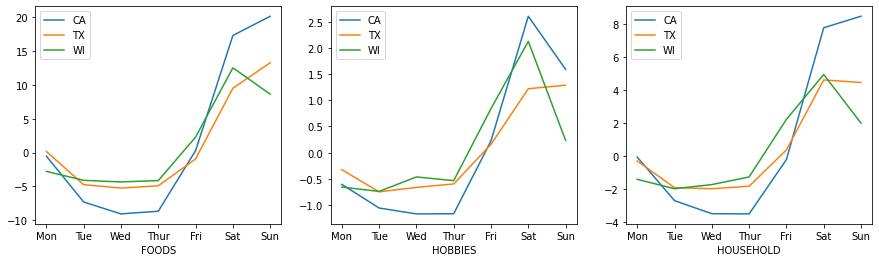

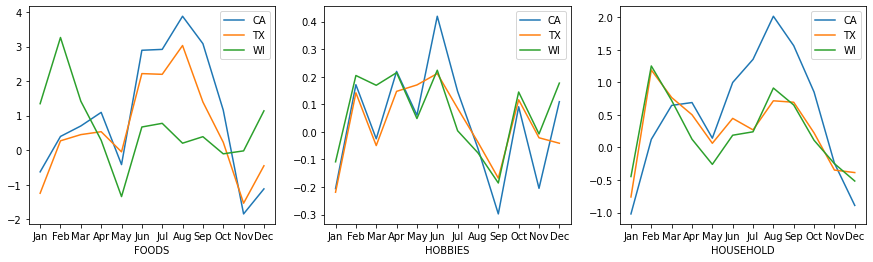

In [17]:
M = F.groupby(['cat_id','state_id'])[(F.columns)[6:]].sum()
A = M
for i in range(9):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
G = A/mean_sales
A = G.groupby(G.columns.map(lambda x : str(x.weekday())),axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (15,4),sharex=True)
for i in range(9):
    ax[(i//3)].plot(A.iloc[i,:],label=A.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = A.index[i][0])
plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
plt.show()

B = G.groupby(G.columns.map(lambda x : x.month),axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (15,4), sharex=True)
for i in range(9):
    ax[(i//3)].plot(B.iloc[i,:],label=B.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = B.index[i][0])
plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# **Event vs Non-event days**

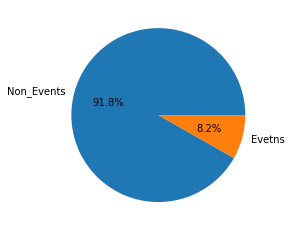

In [18]:
Non_events = cal_df.date.count() - cal_df.event_name_1.count()
Events = cal_df.event_name_1.count()
pd.Series([Non_events,Events], ['Non_Events',"Evetns"],name="").plot.pie(autopct='%1.1f%%')

# **Relative number of types of events**

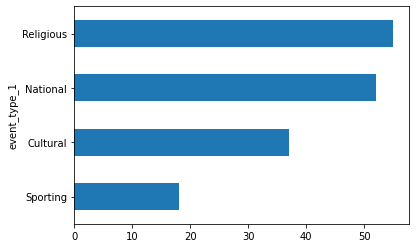

In [19]:
cal_df.groupby(['event_type_1']).count().iloc[:,1].sort_values(ascending=True).plot.barh()

# **SNAP days eac month in different states**

In [20]:
'''import matplotlib as mpl
import calmap

# Import Data
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/yahoo.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

# Plot
plt.figure(figsize=(16,10), dpi= 80)
calmap.calendarplot(df['2014']['VIX.Close'], fig_kws={'figsize': (16,10)}, yearlabel_kws={'color':'black', 'fontsize':14}, subplot_kws={'title':'Yahoo Stock Prices'})
plt.show()'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Settings
years = [2012] 
weeks = [1, 2, 3, 4, 5, 6]
days = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

def generate_data():
    idx = pd.date_range('2012-01-01', periods=182, freq='D')
    return pd.Series(range(len(idx)), index=idx)


def split_months(df, year):
    """
    Take a df, slice by year, and produce a list of months,
    where each month is a 2D array in the shape of the calendar
    :param df: dataframe or series
    :return: matrix for daily values and numerals
    """
    df = df[df.index.year == year]


    # Empty matrices
    a = np.empty((6, 7))
    a[:] = np.nan

    day_nums = {m:np.copy(a) for m in range(1,7)}  # matrix for day numbers
    day_vals = {m:np.copy(a) for m in range(1,7)}  # matrix for day values

    # Logic to shape datetimes to matrices in calendar layout
    for d in df.iteritems():  # use iterrows if you have a DataFrame

        day = d[0].day
        month = d[0].month
        col = d[0].dayofweek

        if d[0].is_month_start:
            row = 0

        day_nums[month][row, col] = day  # day number (0-31)
        day_vals[month][row, col] = d[1] # day value (the heatmap data)

        if col == 6:
            row += 1

    return day_nums, day_vals


def create_year_calendar(day_nums, day_vals, X, name):
    fig, ax = plt.subplots(1, 6, figsize=(20, 12))

    for i, axs in enumerate(ax.flat):

        axs.imshow(day_vals[i+1], cmap='viridis', vmin=1, vmax=365)  # heatmap
        axs.set_title(month_names[i])

        # Labels
        axs.set_xticks(np.arange(len(days)))
        axs.set_xticklabels(days, fontsize=10, fontweight='bold', color='#555555')
        axs.set_yticklabels([])

        # Tick marks
        axs.tick_params(axis=u'both', which=u'both', length=0)  # remove tick marks
        axs.xaxis.tick_top()

        # Modify tick locations for proper grid placement
        axs.set_xticks(np.arange(-.5, 6, 1), minor=True)
        axs.set_yticks(np.arange(-.5, 6, 1), minor=True)
        axs.grid(which='minor', color='w', linestyle='-', linewidth=2.1)

        # Despine
        for edge in ['left', 'right', 'bottom', 'top']:
            axs.spines[edge].set_color('#FFFFFF')

        # Annotate
        for w in range(len(weeks)):
            for d in range(len(days)):
                day_num = day_nums[i+1][w, d]
                if not np.isnan(day_num):    # Value label
                    axs.text(d, w, f"{day_num:0.0f}",
                             ha="center", va="center",
                             fontsize=15, color="k", alpha=0.8)
                    patch_coords = ((d - 0.5, w - 0.5),
                                    (d - 0.5, w + 0.5),
                                    (d + 0.5, w + 0.5),
                                    (d + 0.5, w - 0.5))
                    if datetime.datetime.strptime(str(years[0])+'-'+str(i+1)+'-'+str(int(day_num)), '%Y-%m-%d').date().strftime('%Y-%m-%d') in X:
                        square = Polygon(patch_coords, fc='#FF4500')  #FF4500
                        axs.add_artist(square)
                    else:
                        square = Polygon(patch_coords, fc='#DDDDDD')
                        axs.add_artist(square)

    # Final adjustments
    fig.suptitle(name + ' 2012', fontsize=20)
    plt.subplots_adjust(left=0.04, right=0.96, top=1, bottom=0.65)
    plt.show()

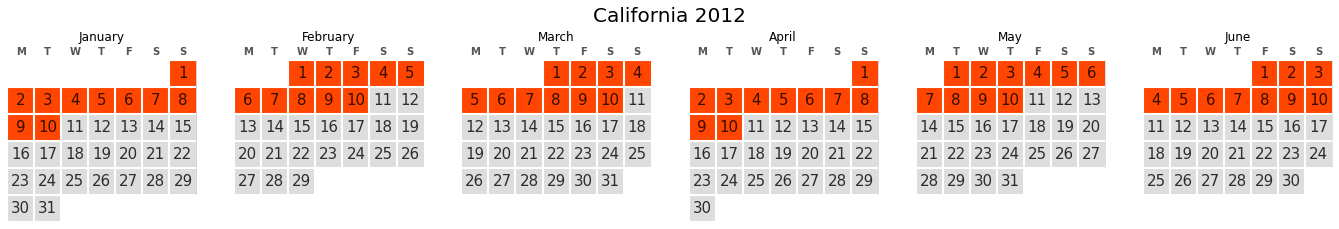

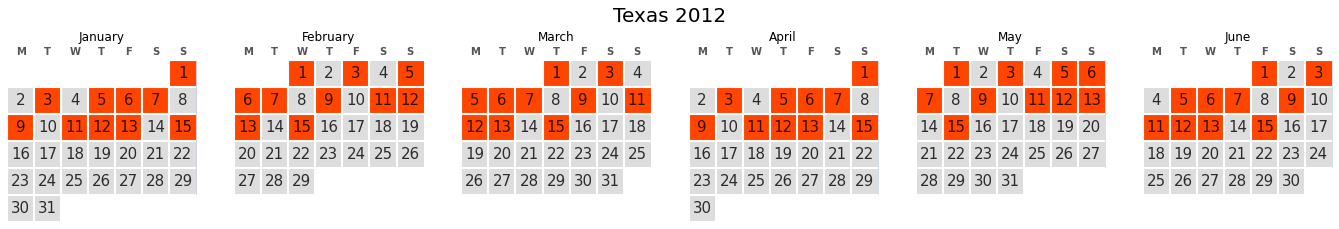

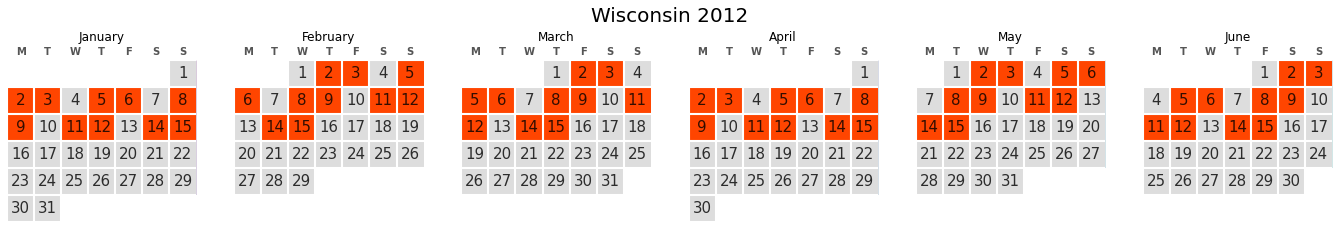

In [21]:
CA = cal_df.date[cal_df.snap_CA == 1].values
TX = cal_df.date[cal_df.snap_TX == 1].values
WI = cal_df.date[cal_df.snap_WI == 1].values
df = generate_data()
day_nums, day_vals = split_months(df,2012)
create_year_calendar(day_nums, day_vals,CA,'California')
create_year_calendar(day_nums, day_vals,TX,'Texas')
create_year_calendar(day_nums, day_vals,WI,'Wisconsin')


# **Item prices distributions of different departments of three states**

In [22]:
A = price_df.groupby([price_df.store_id.str.slice(0,-2),price_df.item_id.str.slice(0,-4)])
B = []
for name, group in A:
    B.append(name)

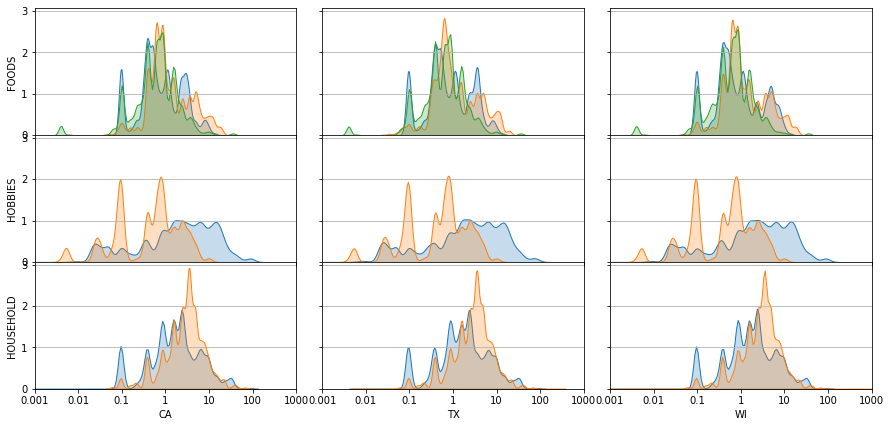

In [23]:
import seaborn as sns
fig, ax = plt.subplots(3,3,sharey=True,sharex=True, figsize=(15,7))
k=0
for j in range(3):
    for i in range(0,1):
        sns.kdeplot(np.log10(A.get_group(B[k])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+1])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+2])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1else'WI'), ylabel ="FOODS")
    for i in range(1,2):
        sns.kdeplot(np.log10(A.get_group(B[k+3])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+4])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1else'WI'),ylabel = "HOBBIES")
    for i in range(2,3):
        sns.kdeplot(np.log10(A.get_group(B[k+5])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        sns.kdeplot(np.log10(A.get_group(B[k+6])['sell_price']),legend=False,bw=0.1,shade=True,ax=ax[i,j])
        ax[i,j].grid(b=True,axis='y')
        ax[i,j].set(xlabel = 'CA' if j==0 else('TX' if j==1else'WI'),ylabel ="HOUSEHOLD")
    k=k+7
fig.canvas.draw()
loc,labels = plt.xticks()
for ax in ax.flat:
    ax.label_outer()
    ax.set_xlim(-1,2)
    ax.set_xticklabels([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
fig.subplots_adjust( hspace = 0.0,wspace=0.1)
plt.show()

# **Item prices distributions of different departments per year**

In [24]:
A=price_df.groupby([price_df.item_id.str.slice(0,-4),price_df.wm_yr_wk//100 + 1900])['sell_price']
n = []
for name,group in A:
    n.append(name)
    
    

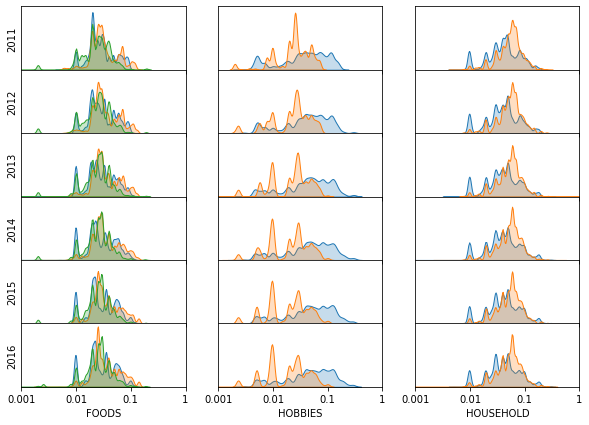

In [25]:
import seaborn as sns
fig, ax = plt.subplots(6,3,sharey=True,sharex=True, figsize=(10,7))

for i in n:
    j = 0 if i[0][:-2]=='FOODS' else (1 if i[0][:-2]=='HOBBIES' else 2)
    k = i[1] - 2011
    sns.kdeplot(np.log10(A.get_group(i)),legend=False,bw=0.1,shade=True,ax=ax[k,j])
    ax[k,j].set(xlabel = i[0][:-2], ylabel =k+2011)
fig.canvas.draw()
loc,labels = plt.xticks()
for ax in ax.flat:
    ax.label_outer()
    ax.set_xlim(-1,2)
    ax.set_xticklabels([10 ** int(i.get_text().replace(u'\u2212', '-')) for i in labels])
plt.yticks([], [])
fig.subplots_adjust( hspace = 0.0,wspace=0.2)
plt.show()

# **Sales per category during Event and Non-Event days**

In [26]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_df.drop(labels=c,axis=1)
event_dates = cal_df[pd.notnull(cal_df['event_name_1'])]['date'] 
event_dates = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates.values]

for i in c:
    event_dates.remove(i)
event_sales = F[['id','dept_id','cat_id', 'store_id', 'state_id']+event_dates[:-8]]
nevent_sales = F[F.drop(columns=event_dates[:-8]).columns]


In [27]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = event_sales.groupby(['cat_id']).sum()
ne = nevent_sales.groupby(['cat_id']).sum()
t = F.groupby(['cat_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e.iloc[i,:].values, range(e.shape[1]),frac=0.4)
    n2 = lowess(ne.iloc[i,:].values, range(ne.shape[1]),frac=0.4)
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.4)
    L1.append(n1[:,1])
    L2.append(n2[:,1])
    L3.append(n3[:,1])
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)
L1 = pd.DataFrame(L1,columns = e.columns)
L2 = pd.DataFrame(L2,columns = ne.columns)
L3 = pd.DataFrame(L3,columns = t.columns)


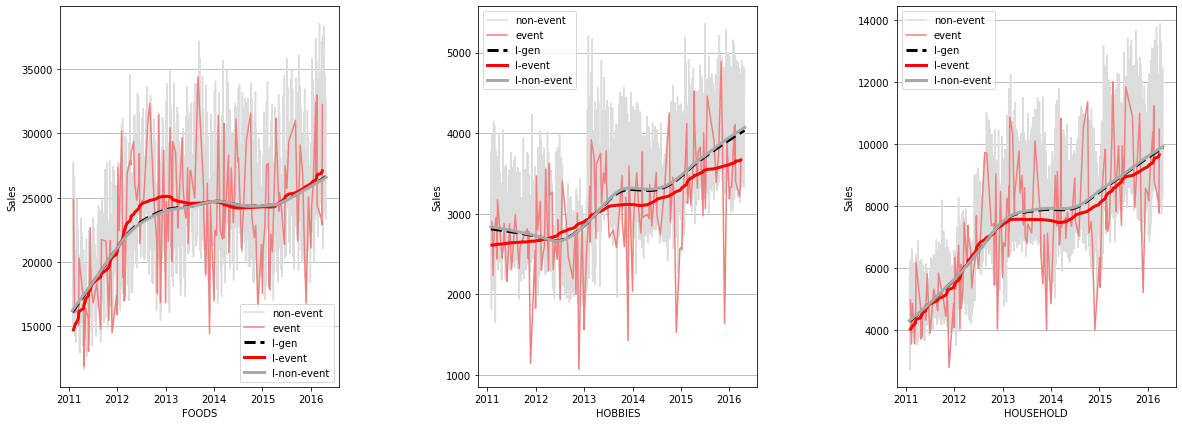

In [28]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
for j in range(3):
    ax[j].plot(ne.iloc[j,:] ,color='gainsboro', label = 'non-event')
    ax[j].plot(e.iloc[j,:] ,color='lightcoral',label = 'event') 
    ax[j].plot(L3.iloc[j,:] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1.iloc[j,:] ,color='red',label = 'l-event',linewidth=3)   
    ax[j].plot(L2.iloc[j,:] ,color = 'darkgray',label = 'l-non-event',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()


In [29]:
N1 = N3[event_dates[:-8]].T.assign(Event='True')
N2 = N3[N3.drop(columns=event_dates[:-8]).columns].T.assign(Event='False')
cdf = pd.concat([N1,N2])
mdf = pd.melt(cdf, id_vars=['Event'], var_name=['Letter'])

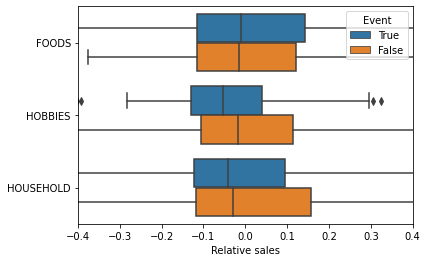

In [30]:
a = sns.boxplot(x="value", y="Letter", hue="Event", data=mdf, orient='h') 

a.set(xlabel="Relative sales",ylabel='')
a.set_xlim(-0.4, 0.4)
plt.show()

In [31]:
N3 = []
means = []
t = F.groupby(['cat_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_df.drop(labels=c,axis=1)
event_dates = cal_df[pd.notnull(cal_df['event_name_1'])][['date','event_type_1']] 
event_dates['date'] = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates['date']]

for i in c:
    event_dates = event_dates[event_dates['date'] != i]


s = N3.T
s.reset_index(drop=False, inplace=True)
s.rename(columns = {'index':'date'},inplace=True)
s = pd.merge(left=event_dates, right=s, how='left', left_on='date', right_on='date')

s = s.groupby(['event_type_1']).median()
s.reset_index(drop=False, inplace=True)
s = s.melt(id_vars=['event_type_1'], value_vars=s.columns[1:])

[Text(0, 0.5, ''), Text(0.5, 0, 'Median sales')]

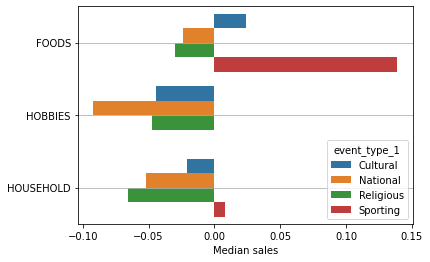

In [32]:
a=sns.barplot(x=s.value,y=s.variable,hue=s.event_type_1)
a.grid(b=True,axis='y')
a.set(xlabel="Median sales",ylabel='')

# **Sales in different states during Event and Non-event days**

In [33]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_df.drop(labels=c,axis=1)
event_dates = cal_df[pd.notnull(cal_df['event_name_1'])]['date'] 
event_dates = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates.values]

for i in c:
    event_dates.remove(i)
event_sales = F[['id','dept_id','cat_id', 'store_id', 'state_id']+event_dates[:-8]]
nevent_sales = F[F.drop(columns=event_dates[:-8]).columns]

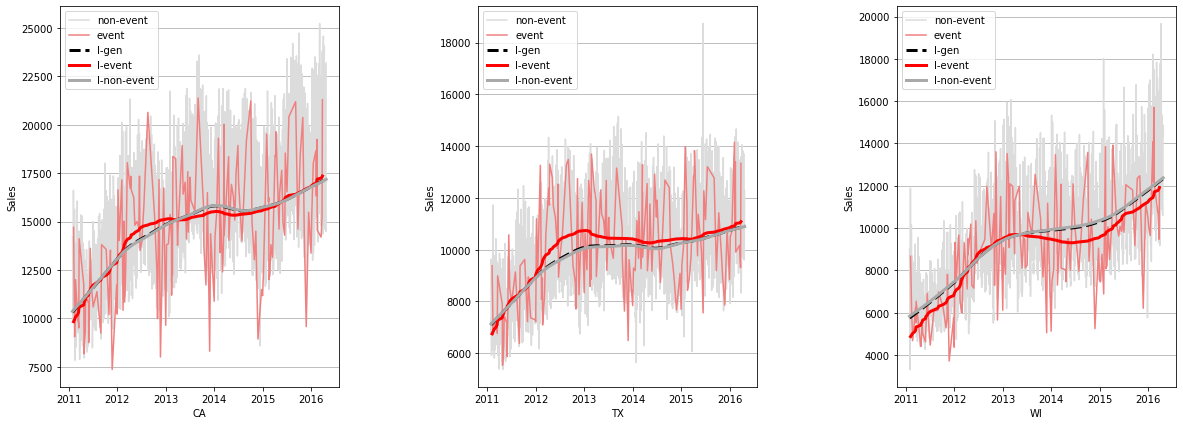

In [34]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = event_sales.groupby(['state_id']).sum()
ne = nevent_sales.groupby(['state_id']).sum()
t = F.groupby(['state_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e.iloc[i,:].values, range(e.shape[1]),frac=0.4)
    n2 = lowess(ne.iloc[i,:].values, range(ne.shape[1]),frac=0.4)
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.4)
    L1.append(n1[:,1])
    L2.append(n2[:,1])
    L3.append(n3[:,1])
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)
L1 = pd.DataFrame(L1,columns = e.columns)
L2 = pd.DataFrame(L2,columns = ne.columns)
L3 = pd.DataFrame(L3,columns = t.columns)
fig, ax = plt.subplots(1,3, figsize=(20,7))
for j in range(3):
    ax[j].plot(ne.iloc[j,:] ,color='gainsboro', label = 'non-event')
    ax[j].plot(e.iloc[j,:] ,color='lightcoral',label = 'event') 
    ax[j].plot(L3.iloc[j,:] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1.iloc[j,:] ,color='red',label = 'l-event',linewidth=3)   
    ax[j].plot(L2.iloc[j,:] ,color = 'darkgray',label = 'l-non-event',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()


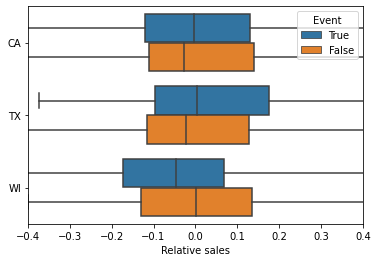

In [35]:
N1 = N3[event_dates[:-8]].T.assign(Event='True')
N2 = N3[N3.drop(columns=event_dates[:-8]).columns].T.assign(Event='False')
cdf = pd.concat([N1,N2])
mdf = pd.melt(cdf, id_vars=['Event'], var_name=['Letter'])
a = sns.boxplot(x="value", y="Letter", hue="Event", data=mdf, orient='h') 

a.set(xlabel="Relative sales",ylabel='')
a.set_xlim(-0.4, 0.4)
plt.show()

[Text(0, 0.5, ''), Text(0.5, 0, 'Median sales')]

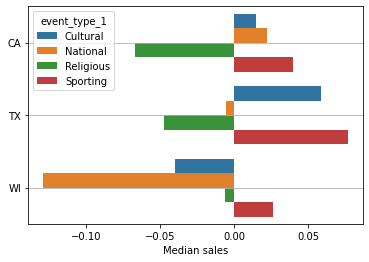

In [36]:

N3 = []
means = []
t = F.groupby(['state_id']).sum()
means = t.mean(axis=1)
for i in range(3):
    n3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n3 = (t.iloc[i,:] - n3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

event_dates = cal_df[pd.notnull(cal_df['event_name_1'])][['date','event_type_1']] 
event_dates['date'] = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in event_dates['date'].values]
for i in c:
    event_dates = event_dates[event_dates['date'] != i]
event_dates = event_dates.iloc[:-8,:]

s = N3.T
s.reset_index(drop=False, inplace=True)
s.rename(columns = {'index':'date'},inplace=True)
s = pd.merge(left=event_dates, right=s, how='left', left_on='date', right_on='date')

s = s.groupby(['event_type_1']).median()
s.reset_index(drop=False, inplace=True)
s = s.melt(id_vars=['event_type_1'], value_vars=s.columns[1:])


a=sns.barplot(x=s.value,y=s.variable,hue=s.event_type_1)
a.grid(b=True,axis='y')
a.set(xlabel="Median sales",ylabel='')

# **Sales per state on SNAP vs Non-SNAP days**

In [37]:
c = [datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)]
F = sale_df.drop(labels=c,axis=1)
F = F.groupby(['state_id']).sum()
CA_snap = cal_df.date[cal_df.snap_CA == 1].values
TX_snap = cal_df.date[cal_df.snap_TX == 1].values
WI_snap = cal_df.date[cal_df.snap_WI == 1].values
CA_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in CA_snap]
TX_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in TX_snap]
WI_snap = [datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in WI_snap]

CA_snap_sales = F[CA_snap[:-20]].iloc[0,:]
TX_snap_sales = F[TX_snap[:-20]].iloc[1,:]
WI_snap_sales = F[WI_snap[:-20]].iloc[2,:]

CA_nsnap_sales = F[F.drop(columns=CA_snap[:-20]).columns].iloc[0,:]
TX_nsnap_sales = F[F.drop(columns=TX_snap[:-20]).columns].iloc[1,:]
WI_nsnap_sales = F[F.drop(columns=WI_snap[:-20]).columns].iloc[2,:]


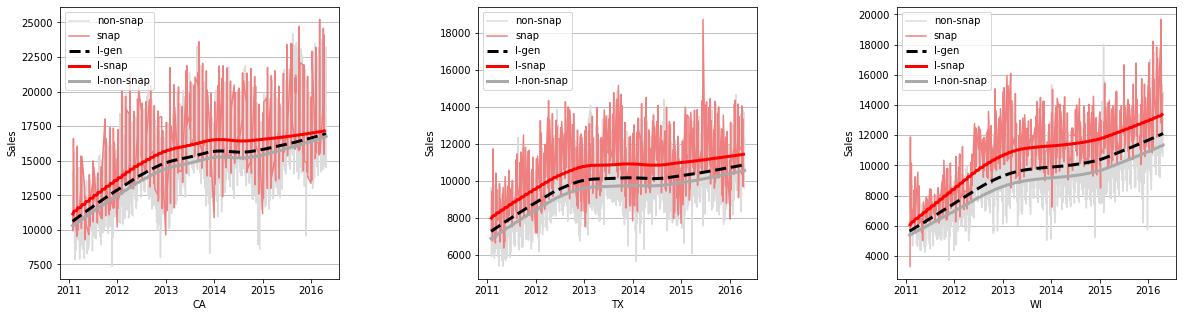

In [38]:
N3 = []
L1 = []
L2 = []
L3 = []
means = []
e = [CA_snap_sales,TX_snap_sales,WI_snap_sales]
ne = [CA_nsnap_sales,TX_nsnap_sales,WI_nsnap_sales]
t = F
means = t.mean(axis=1)
for i in range(3):
    n1 = lowess(e[i].values, range(len(e[i])),frac=0.5)
    n2 = lowess(ne[i].values, range(len(ne[i])),frac=0.5)
    nn3 = lowess(t.iloc[i,:].values, range(t.shape[1]),frac=0.5)
    n1 = pd.Series(n1[:,1],e[i].index)
    n2 = pd.Series(n2[:,1],ne[i].index)
    n3 = pd.Series(nn3[:,1],t.columns)
    L1.append(n1)
    L2.append(n2)
    L3.append(n3)
    n3 = (t.iloc[i,:] - nn3[:,1]) /(means[i])
    N3.append(n3)
N3 = pd.DataFrame(N3,columns = t.columns)

fig, ax = plt.subplots(1,3, figsize=(20,5))
for j in range(3):
    ax[j].plot(ne[j] ,color='gainsboro', label = 'non-snap')
    ax[j].plot(e[j],color='lightcoral',label = 'snap') 
    ax[j].plot(L3[j] ,color = 'black', linestyle= 'dashed',label = 'l-gen',linewidth=3) 
    ax[j].plot(L1[j] ,color='red',label = 'l-snap',linewidth=3)   
    ax[j].plot(L2[j] ,color = 'darkgray',label = 'l-non-snap',linewidth=3) 
    ax[j].grid(b=True,axis='y')
    ax[j].legend(loc='best')
    ax[j].set(xlabel = t.index[j] ,ylabel = 'Sales')

fig.subplots_adjust( hspace = 0.0,wspace=0.5)
plt.show()


# **Daily Sales percentage on SNAP and Non-SNAP days**

In [39]:
perc = []
for i in range(3):
    a = e[i].sum()/(1908/3)
    b = ne[i].sum()/(2*1908/3)
    perc.append([a*100/(a+b), b*100/(a+b)])

perc = pd.DataFrame(perc,index=["CA","TX","WI"],columns=["SNAP","NON_SNAP"])
perc.reset_index(drop=False, inplace=True)
s = perc.melt(id_vars=['index'], value_vars=perc.columns[1:])
s = s.sort_values(by='index',ignore_index=True)

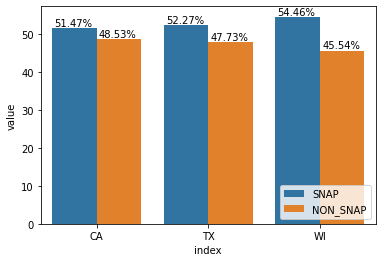

In [40]:
ax = sns.barplot(y=s.value,hue=s.variable,x=s['index'])
ax.legend(loc = 'lower right')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height()+'%', xy=(p.get_x()+p.get_width()/2,p.get_height()),
            xytext=(-20,5), textcoords='offset points', ha="left", va="center")

# **Daily Sales percentage on SNAP and Non-SNAP days per category**

In [41]:
F  = sale_df.groupby(['state_id','cat_id']).sum()
F.reset_index(drop=False, inplace=True)
l = [CA_snap[:-20],TX_snap[:-20],WI_snap[:-20]]

t = []
for i in range(9):
    t.append((F['state_id'][i],F['cat_id'][i]))
    
a=[]
b = []
perc = []
for i in range(9):
    a.append(F[l[i//3]].loc[i,:].sum()/(1908/3))
    b.append(F[F.drop(columns=l[i//3]).columns].iloc[i,3:].sum()/(2*1908/3))
    perc.append([a[i]*100/(a[i]+b[i]), b[i]*100/(a[i]+b[i])])
perc = pd.DataFrame(perc,index=t,columns=["SNAP","NON_SNAP"])
perc.reset_index(drop=False, inplace=True)
s = perc.melt(id_vars=['index'], value_vars=perc.columns[1:])
s = s.sort_values(by='index',ignore_index=True)

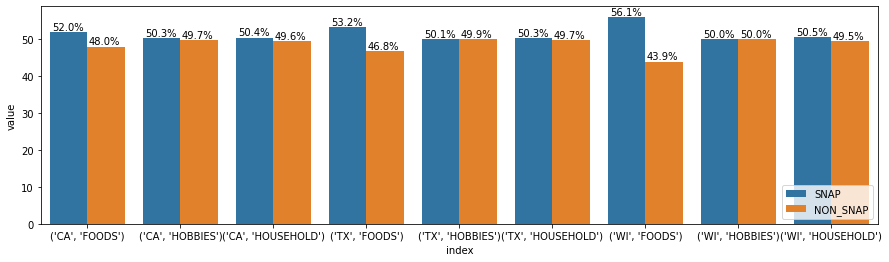

In [42]:
fig, ax = plt.subplots(figsize=(15,4))
ax = sns.barplot(y=s.value,hue=s.variable,x=s['index'])
ax.legend(loc = 'lower right')

for p in ax.patches:
    ax.annotate("%.1f" % p.get_height()+'%', xy=(p.get_x()+p.get_width()/2,p.get_height()),
            xytext=(-17,5), textcoords='offset points', ha="left", va="center")


# **SNAP impact on Food sales in CA**
Relative sales on SNAP days - Relative sales on other days
Red -- high SNAP effect and Blue -- low SNAP effect

In [43]:
z = F.drop(labels=c,axis=1).iloc[0,2:]
n1 = lowess(z.values, range(1908),frac=0.5)
rel_sales = (z.values - n1[:,1]) / z.mean()
rel_sales = pd.Series(rel_sales,z.index)

rel_sales1 = rel_sales[CA_snap[:-20]]
rel_sales2 = rel_sales.drop(labels = CA_snap[:-20])

a = rel_sales1.groupby(rel_sales1.index.map(lambda x : str(x.weekday())+'-'+str(x.month))).sum()
b = rel_sales2.groupby(rel_sales2.index.map(lambda x : str(x.weekday())+'-'+str(x.month))).sum()

H = np.zeros((7,12))
for i in range(7):
    for j in range(12):
        H[i,j] = a[str(i)+'-'+str(j+1)] - b[str(i)+'-'+str(j+1)]

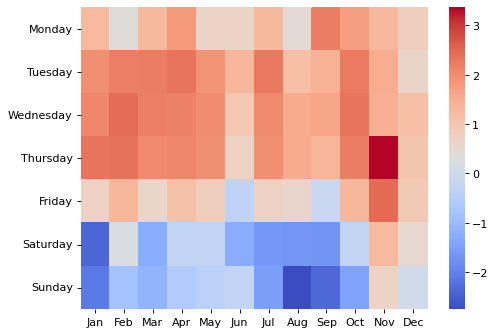

In [44]:
import seaborn as sns
plt.figure(None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(H,cmap='coolwarm',xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday' ])
plt.show()

# **Sales for Three random items in mid of 2015 with Black points as Events and Gray Background representing SNAP days**

In [45]:
x = sale_df[sale_df['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].loc[:,datetime.date(2015,5,1):datetime.date(2015,10,1)]

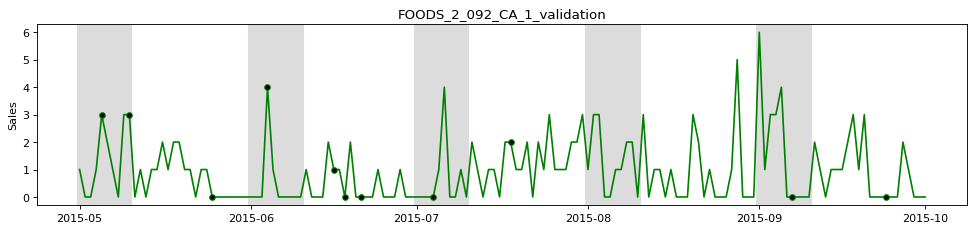

In [46]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(CA_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[0,:], '-gd', markevery = d,markerfacecolor='black',marker='.',markersize=10)
plt.title("FOODS_2_092_CA_1_validation")
plt.ylabel("Sales")
plt.show()

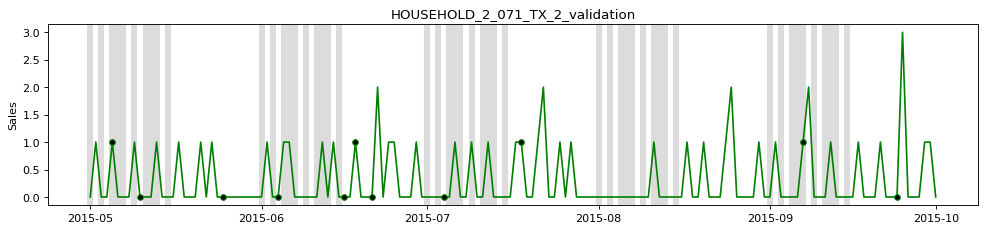

In [47]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(TX_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
plt.figure(None, figsize=(15,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[1,:], '-gd', markevery = d,markerfacecolor='black',marker='.',markersize=10)
plt.title("HOUSEHOLD_2_071_TX_2_validation")
plt.ylabel("Sales")
plt.show()


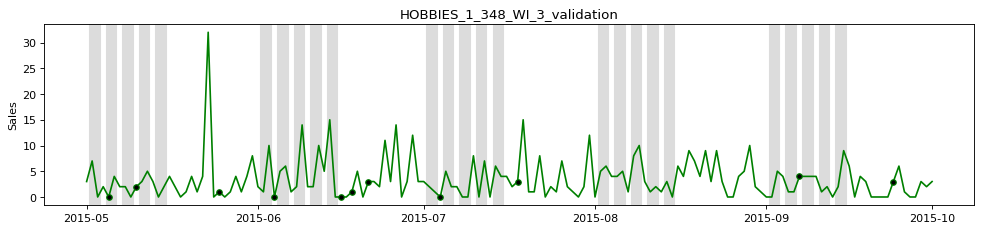

In [48]:
v = event_dates[event_dates['date'].isin([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)])]['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = list(set(WI_snap) & set([datetime.date(2015,5,1) + datetime.timedelta(days=x) for x in range(153)]))
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='gainsboro',linewidth=5.5)
plt.plot(x.iloc[2,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.title("HOBBIES_1_348_WI_3_validation")
plt.ylabel("Sales")
plt.show()

# **Sales of 3 random items with price change in background**

In [49]:
import matplotlib
x = sale_df[sale_df['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].iloc[:,6:]

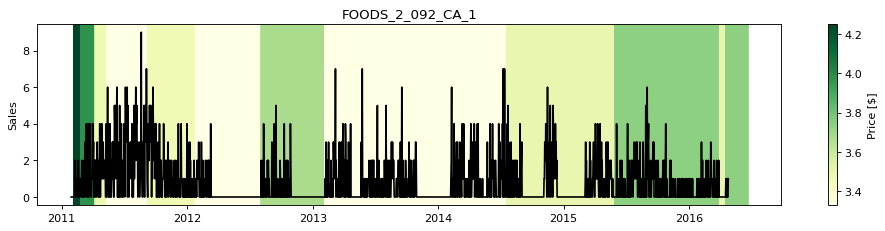

In [50]:
z = price_df[(price_df['store_id']=='CA_1') & (price_df['item_id']=='FOODS_2_092')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
u = u[1:]
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)
    
plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()), cmap='YlGn').to_rgba(u[i]))
plt.plot(x.iloc[0,:],color='black')
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()), cmap='YlGn'),label='Price [$]')
plt.title("FOODS_2_092_CA_1")
plt.ylabel("Sales")
plt.show()

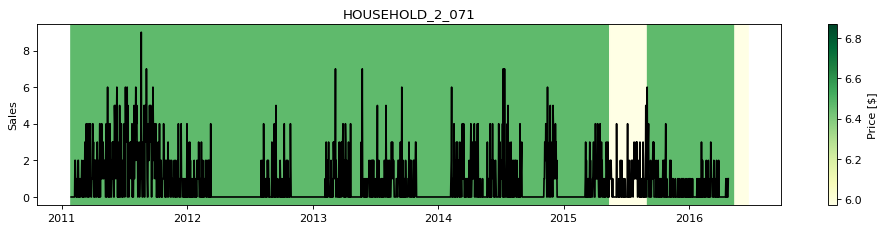

In [51]:
z = price_df[(price_df['store_id']=='TX_2') & (price_df['item_id']=='HOUSEHOLD_2_071')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.4), cmap='YlGn').to_rgba(u[i]))
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.4), cmap='YlGn'),label='Price [$]')
plt.plot(x.iloc[0,:],color='black')
plt.title("HOUSEHOLD_2_071")
plt.ylabel("Sales")
plt.show()

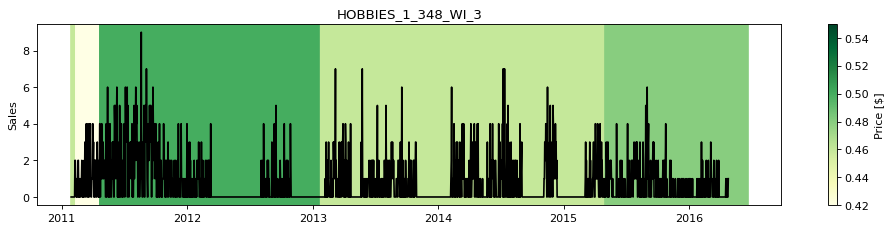

In [52]:
z = price_df[(price_df['store_id']=='WI_3') & (price_df['item_id']=='HOBBIES_1_348')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
u = z.sell_price.unique()
y = []
for i in u:
    y.append(z.groupby(['sell_price']).get_group(i)['date'].values)

plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y)):
    for j in range(len(y[i])):
        plt.axvline(y[i][j],color=matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.05), cmap='YlGn').to_rgba(u[i]))
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=u.min(), vmax=u.max()+0.05), cmap='YlGn'),label='Price [$]')
plt.plot(x.iloc[0,:],color='black')
plt.title("HOBBIES_1_348_WI_3")
plt.ylabel("Sales")
plt.show()

# **Sales of 3 items with Gray background representing SNAP days, Black dots represting Events and Yellow line representing Scaled Prices**

In [53]:
x = sale_df[sale_df['id'].isin(["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"])].iloc[:,6:]


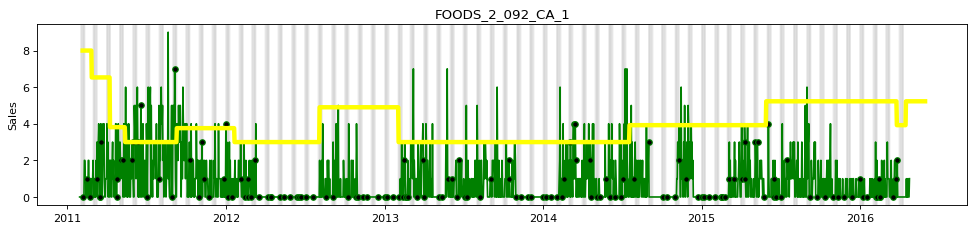

In [54]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = CA_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = price_df[(price_df['store_id']=='CA_1') & (price_df['item_id']=='FOODS_2_092')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (8-3)) / (z.sell_price.max() - z.sell_price.min())) + 3)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[0,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("FOODS_2_092_CA_1")
plt.ylabel("Sales")
plt.show()

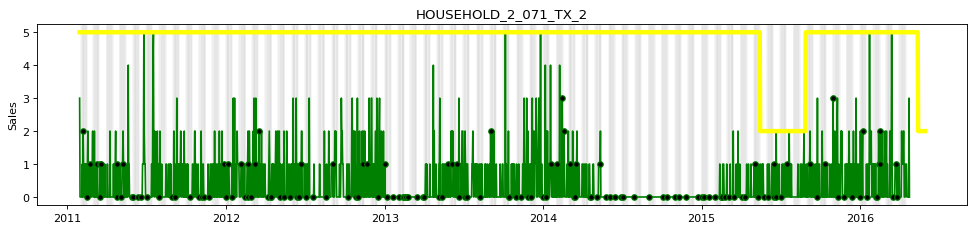

In [55]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = TX_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = price_df[(price_df['store_id']=='TX_2') & (price_df['item_id']=='HOUSEHOLD_2_071')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (5-2)) / (z.sell_price.max() - z.sell_price.min())) + 2)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[1,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("HOUSEHOLD_2_071_TX_2")
plt.ylabel("Sales")
plt.show()

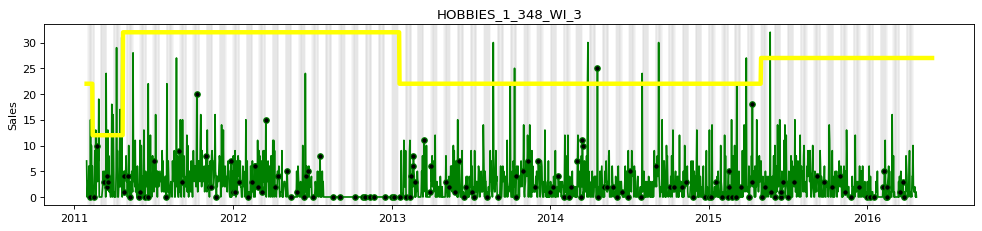

In [56]:
v = event_dates['date']
d = []
for i in range(len(v)):
    d.append(x.columns.get_loc(v.values[i]))   
c = WI_snap[:-20]
e = []
for i in range(len(c)):
    e.append(x.columns.get_loc(c[i]))
    
z = price_df[(price_df['store_id']=='WI_3') & (price_df['item_id']=='HOBBIES_1_348')]
z = cal_df[['date','wm_yr_wk']].merge(z[['sell_price','wm_yr_wk']], how='left',on='wm_yr_wk')
z['date']=z['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d').date())
z['sell_price'] = z['sell_price'].apply(lambda x : (((x - z.sell_price.min()) * (32-12)) / (z.sell_price.max() - z.sell_price.min())) + 12)
z = z.iloc[:-20,:]
z = z.set_index('date')


plt.figure(None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(c)):
    plt.axvline(c[i],color='dimgray',linewidth=0.1)
plt.plot(x.iloc[2,:], '-gd', markevery = d, markerfacecolor='black',marker='.',markersize=10)
plt.plot(z.sell_price,color='yellow',linewidth=4)
plt.title("HOBBIES_1_348_WI_3")
plt.ylabel("Sales")
plt.show()